# Load dataset and summary

In [26]:
# Code to load images and labels taken from
#     walkthrough_for_how_to_handle_folder_structure_and_images.ipynb

# Import necessary libraries.
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
from google.colab import drive
from os import listdir, walk
from os.path import isfile, join
from glob import glob
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow

%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

warnings.filterwarnings('ignore')

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Set the path to the dataset folder. (The dataset contains image folder: "train")
train_path = "/content/drive/MyDrive/Colab Notebooks/data/plant_seedlings/train.zip"
#path = './temp_train/train/Charlock'

#a = [f for f in listdir(path) if join(path, f)]
#print(a)

In [28]:
# Make different folders for train and test data in the current directory of Google Colab notebook. (using mkdir)
!mkdir temp_train

mkdir: cannot create directory ‘temp_train’: File exists


In [29]:
# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall('./temp_train')

In [30]:
path = "./temp_train/train/*/*.png"                              # The path to all images in training set. (* means include all folders and files.)
#path = "./temp_train/train/Charlock/c9601d3ab.png"
files = glob(path)

#print(os.listdir('./temp_train/train'))

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

print('Processing', num, 'files')

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print('All files processed')

Processing 4750 files
All files processed


In [31]:
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750, 1)


Charlock :


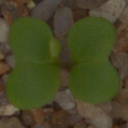


Fat Hen :


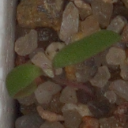


Scentless Mayweed :


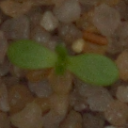

In [32]:
print(trainLabel[0][0], ':')
cv2_imshow(trainImg[0])
print('')
print(trainLabel[0][3000], ':')
cv2_imshow(trainImg[3000])
print('')
print(trainLabel[0][4351], ':')
cv2_imshow(trainImg[4351])

# Data Pre-processing

* Normalization
* Gaussian blurring
* Visualize data after pre-processing

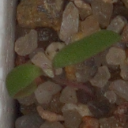

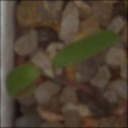

In [33]:
# Gaussian blurring
from scipy.signal import convolve2d

# 5x5 Gaussian Blur kernel with sigma of 1.0
kernel = np.array([[0.003765,0.015019,0.023792,0.015019,0.003765],
                   [0.015019,0.059912,0.094907,0.059912,0.015019],
                   [0.023792,0.094907,0.150342,0.094907,0.023792],
                   [0.015019,0.059912,0.094907,0.059912,0.015019],
                   [0.003765,0.015019,0.023792,0.015019,0.003765]])

cv2_imshow(trainImg[3000])

for img in trainImg:
  for i in range(img.shape[-1]):
    img[:,:,i] = convolve2d(img[:,:,i], kernel, mode='same')

cv2_imshow(trainImg[3000])

In [34]:
# Split the dataset into training/testing (.7/.3) and testing/validation (.5/.5)
from sklearn.model_selection import train_test_split as tts

x_train, x_test, y_train, y_test = tts(trainImg, trainLabel, test_size=.3, random_state=42)

In [35]:
x_test, x_val, y_test, y_val = tts(x_test, y_test, test_size=.5, random_state=42)

In [36]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(3325, 128, 128, 3)
(712, 128, 128, 3)
(713, 128, 128, 3)


In [37]:
# Reshape (it's already in the correct shape, but just in case) and normalize
x_train = x_train.reshape(x_train.shape[0], 128, 128, 3)
x_test = x_test.reshape(x_test.shape[0], 128, 128, 3)
x_val = x_val.reshape(x_val.shape[0], 128, 128, 3)

In [38]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

x_train /= 255
x_test /= 255
x_val /= 255

In [39]:
print("x_train shape:", x_train.shape)
print("Images in x_train:", x_train.shape[0])
print("Images in x_test:", x_test.shape[0])
print("Images in x_val:", x_val.shape[0])
print("Min/max values in x_train:", x_train.min(), x_train.max())

x_train shape: (3325, 128, 128, 3)
Images in x_train: 3325
Images in x_test: 712
Images in x_val: 713
Min/max values in x_train: 0.0 0.99607843


In [40]:
replaceStruct = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

y_train = y_train.replace(replaceStruct)
y_test = y_test.replace(replaceStruct)
y_val = y_val.replace(replaceStruct)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [41]:
from tensorflow.keras import utils

y_train = utils.to_categorical(y_train, num_classes=12)
y_test = utils.to_categorical(y_test, num_classes=12)
y_val = utils.to_categorical(y_val, num_classes=12)

In [42]:
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [43]:
# Build convolutional neural network
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu', padding='same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Flatten())

classifier.add(Dense(units=512, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=12, activation='softmax'))

In [44]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('./temp_train/train',
                                                 target_size=(128,128),
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('./temp_train/train',
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')

classifier.fit(training_set,
               steps_per_epoch=int(3325/32),
               epochs=10,
               validation_data=test_set,
               validation_steps=int(712/32))

Found 4750 images belonging to 12 classes.
Found 4750 images belonging to 12 classes.
Epoch 1/10
103/103 [==============================] - 117s 1s/step - loss: 2.3738 - accuracy: 0.1815 - val_loss: 1.6845 - val_accuracy: 0.4545
Epoch 2/10
103/103 [==============================] - 116s 1s/step - loss: 1.7208 - accuracy: 0.3966 - val_loss: 1.3311 - val_accuracy: 0.5043
Epoch 3/10
103/103 [==============================] - 115s 1s/step - loss: 1.4029 - accuracy: 0.5053 - val_loss: 1.0650 - val_accuracy: 0.6222
Epoch 4/10
103/103 [==============================] - 117s 1s/step - loss: 1.2570 - accuracy: 0.5651 - val_loss: 0.9971 - val_accuracy: 0.6250
Epoch 5/10
103/103 [==============================] - 121s 1s/step - loss: 1.1295 - accuracy: 0.6044 - val_loss: 0.8587 - val_accuracy: 0.7415
Epoch 6/10
103/103 [==============================] - 114s 1s/step - loss: 1.0081 - accuracy: 0.6422 - val_loss: 0.7911 - val_accuracy: 0.7301
Epoch 7/10
103/103 [==============================] - 11

In [46]:
y_pred = classifier.predict(x_test)

In [47]:
classifier.evaluate(x_test, y_test, batch_size=8, verbose=1)

89/89 [==============================] - 4s 48ms/step - loss: 5.9269 - accuracy: 0.1643


[5.926920413970947, 0.16432584822177887]

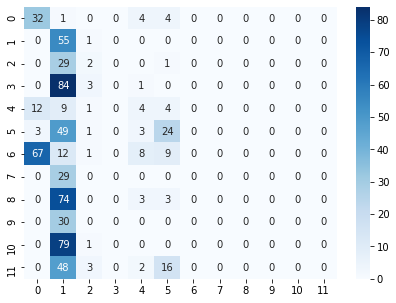

In [48]:
# Confusion matrix
from sklearn import metrics
import seaborn as sns

cm = metrics.confusion_matrix(y_test.argmax(axis=1),
                              y_pred.argmax(axis=1))

cmdf = pd.DataFrame(cm)

plt.figure(figsize=(7,5));
sns.heatmap(cmdf, annot=True, cmap='Blues', fmt='d');

In [49]:
print("LABELED VALUES (not predictions):")
print("y_test[2] ", y_test[2])
print("y_test[3] ", y_test[3])
print("y_test[33]", y_test[33])
print("y_test[36]", y_test[36])
print("y_test[59]", y_test[59])
print('')
print("2: ", "Loose silky-bent")
print("3: ", "Common wheat")
print("33:", "Black-grass")
print("36:", "Black-grass")
print("59:", "Charlock")

LABELED VALUES (not predictions):
y_test[2]  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
y_test[3]  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
y_test[33] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_test[36] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_test[59] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

2:  Loose silky-bent
3:  Common wheat
33: Black-grass
36: Black-grass
59: Charlock


In [50]:
print("PREDICTED VALUES:")
print("y_pred[2] ", np.argmax(y_pred[2]))
print("y_pred[3] ", np.argmax(y_pred[3]))
print("y_pred[33]", np.argmax(y_pred[33]))
print("y_pred[36]", np.argmax(y_pred[36]))
print("y_pred[59]", np.argmax(y_pred[59]))
print('')
print("2: ", "Charlock")
print("3: ", "Charlock")
print("33:", "Black-grass")
print("36:", "Black-grass")
print("59:", "Charlock")

PREDICTED VALUES:
y_pred[2]  1
y_pred[3]  1
y_pred[33] 0
y_pred[36] 0
y_pred[59] 1

2:  Charlock
3:  Charlock
33: Black-grass
36: Black-grass
59: Charlock
